In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
import os
import sys
dir= "/content/drive/MyDrive/Github/DeepLearning2022/ContractReviewer"
os.chdir(dir)

In [ ]:
#!pip install bert-pytorch
!pip install sentencepiece
!pip install transformers
!pip install onnx
!pip install fasttext
!pip install torchtext
!pip install scikit-learn
!pip install d2l==1.0.0-alpha1.post0
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yaml
import argparse
import time
import copy

import torch
import torchtext
from torchtext import datasets
from torch import nn
from d2l import torch as d2l

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.rename(columns={'choice': 'label'}, inplace=True)
test.rename(columns={'choice': 'label'}, inplace=True)

def change_label(x):
  if x == "Entailment":
    return 0
  elif x == "Contradiction":
    return 1
  else:
    return 2

train["label"] = train.label.apply(lambda x: change_label(x))
test["label"]  = test.label.apply(lambda x: change_label(x))

## Will need to implement FIAS Here to update Train dataset for training

In [ ]:
#######################################################################################
#######################################################################################
import json
import pandas as pd
import pickle
import utility as utl
#################
# Opening JSON file
f = open('data/train.json')  
# returns JSON object as 
# a dictionary
data = json.load(f)

kes=['nda-11', 'nda-16', 'nda-15', 'nda-10', 'nda-2', 'nda-1', 'nda-19', 'nda-12', 'nda-20', 'nda-3', 'nda-18', 'nda-7', 'nda-17', 'nda-8', 'nda-13', 'nda-5', 'nda-4']
rg = len(data['documents'])
reference_list=[]
idx=0
for idx in range(rg):
  #Document level
  docid = data['documents'][idx]['id']
  for ndas_key in kes:
    reference_list.append([docid, ndas_key,idx])
  idx=idx+1
ref_train = pd.DataFrame(reference_list ,columns = ['docid', 'nda_key', 'idx'])
f.close()
##############
# Opening JSON file
f = open('data/test.json')  
# returns JSON object as 
# a dictionary
dataT = json.load(f)

kes=['nda-11', 'nda-16', 'nda-15', 'nda-10', 'nda-2', 'nda-1', 'nda-19', 'nda-12', 'nda-20', 'nda-3', 'nda-18', 'nda-7', 'nda-17', 'nda-8', 'nda-13', 'nda-5', 'nda-4']
rg = len(dataT['documents'])
reference_list=[]
idxt=0
for idxt in range(rg):
  #Document level
  docid = dataT['documents'][idxt]['id']

  for ndas_key in kes:
    reference_list.append([docid, ndas_key, idxt])
  idxt=idxt+1
ref_test = pd.DataFrame(reference_list ,columns = ['docid', 'nda_key', 'idx'])
 
# This is one time think and will take around 10 minutes
import os.path
path_to_file = "train.pickle"
if os.path.exists(path_to_file)==False:
    train_dataset= utl.get_data(data, 0,'nda-3') # Dummy dataframe to create structure
    train_dataset = pd.DataFrame(columns= train_dataset.columns)
    for i in range(len(data['documents'])):
      for ke in kes:
        df2= utl.get_data(data, i,ke)
        train_dataset=pd.concat([train_dataset,df2])
    train_dataset.to_pickle(path_to_file)
train = pd.read_pickle(path_to_file)
train = train[['hypotheis', 'premise','label']]
train['label'] = train['label'].astype(int)

path_to_fileT = "test.pickle"
if os.path.exists(path_to_fileT)==False:
    test_dataset= utl.get_data(dataT, 0,'nda-3') # Dummy dataframe to create structure
    test_dataset = pd.DataFrame(columns= test_dataset.columns)
    for i in range(len(dataT['documents'])):
      for ke in kes:
        df2= utl.get_data(dataT, i,ke)
        test_dataset=pd.concat([test_dataset,df2])
    test_dataset.to_pickle(path_to_fileT)
test = pd.read_pickle(path_to_fileT)
test= test[['hypotheis', 'premise','label']]
test['label'] = test['label'].astype(int)

#######################################################################################
#######################################################################################

## End implementation of FIAS

In [ ]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset["hypotheis"])
        all_hypothesis_tokens = d2l.tokenize(dataset["premise"])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset["label"].values) # Sid, I changed to values as it was giving an error
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [ ]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [ ]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [ ]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [ ]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [136]:
#Git Testing
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

def reweight(cls_num_list, beta=0.9999):
    """
    Implement reweighting by effective numbers
    :param cls_num_list: a list containing # of samples of each class
    :param beta: hyper-parameter for reweighting, see paper for more details
    :return:
    """
    per_cls_weights = None
    #############################################################################
    # TODO: reweight each class by effective numbers                            #
    #############################################################################
    per_cls_weights = []
    for cls_num in cls_num_list:
        per_cls_weights.append((1 - beta) / (1 - (beta ** cls_num)))         
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    return per_cls_weights


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.1, device='cpu'):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight
        self.device = device

    def forward(self, input, target):
        """
        Implement forward of focal loss
        :param input: input predictions
        :param target: labels
        :return: tensor of focal loss in scalar
        """
        loss = None
        #############################################################################
        # TODO: Implement forward pass of the focal loss                            #
        #############################################################################
        
        input = input.to(self.device)
        target = target.to(self.device)
        import torch.nn.functional as F
        weight=torch.from_numpy(np.array(self.weight)).float().to(self.device)
        ce_loss = F.cross_entropy(input, target,  weight=weight)
        pt = torch.exp(-ce_loss) 
        foc_loss = ((1 -pt) ** self.gamma * ce_loss)
        loss = foc_loss.mean()
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss

# Hyperparameters

###### best results
###### num_step = 50
###### batch_size= 256
###### learning_rate= 0.001
###### reg= 0.0001
###### epochs= 4
###### steps= [6, 8]
###### warmup= 0
###### momentum= 0.9
###### gamma=3
###### beta= .90
###### max_netural= 10
###### save_best= True
###### model= DecomposableAttention
###### trainer= "Adam" #SGD can be Adam or SGD
###### loss= "Focal" #CrossEntropyLoss can be Focal or CrossEntropyLoss

In [ ]:
def load_config_notebook():
  class Args:
    num_step = 100
    batch_size= 256
    learning_rate= 0.001
    reg= 0.0001
    epochs= 4
    steps= [6, 8]
    warmup= 0
    momentum= 0.9
    gamma=3
    beta= .90
    max_netural= 10
    save_best= True
    model= DecomposableAttention
    trainer= "Adam" #SGD can be Adam or SGD
    loss= "Focal" #CrossEntropyLoss can be Focal or CrossEntropyLoss

  return Args()

args = load_config_notebook()

## Training Model

loss 0.000, train acc 0.933, test acc 0.915
8811.1 examples/sec on [device(type='cuda', index=0)]


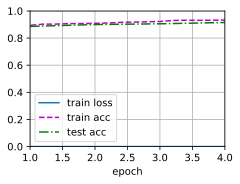

In [ ]:
#############################################################
# Create Dataset
#############################################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_steps = args.num_step
batch_size = args.batch_size
num_workers = d2l.get_dataloader_workers()
train_set = SNLIDataset(train, num_steps)
test_set = SNLIDataset(test, num_steps, train_set.vocab)
vocab = train_set.vocab
train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                        shuffle=False,
                                        num_workers=num_workers)
#############################################################
# Set Up Model and Glove components
#############################################################
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

#############################################################
# Train Model
#############################################################

#reweight labels
a = train.label.value_counts()
cls_num_list = list([a[0],a[1],a[2]])
per_cls_weights =  reweight(cls_num_list, beta=args.beta)
#batch_size, num_steps = 128, 50
#lr, num_epochs = 0.001, 4

#hyperparam criterion
if args.trainer == "Adam":
  trainer = torch.optim.Adam(net.parameters(), lr=args.learning_rate)
else:
  trainer = torch.optim.SGD(net.parameters(), lr=args.learning_rate,\
                            momentum=args.momentum)
#hyperparam loss function
if args.loss == "Focal":
  loss = FocalLoss(weight=per_cls_weights, gamma=args.gamma).to(device)
else:
  loss = nn.CrossEntropyLoss(reduction="none")


d2l.train_ch13(net, train_iter, test_iter, loss, trainer, args.epochs, devices)

## Testing and Prediction

In [ ]:
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'Entailment' if label == 0 else 'Contradiction' if label == 1 \
            else 'neutral'

In [ ]:
predict_snli(net, vocab, train.iloc[4, :]["premise"].split(), \
             train.iloc[4, :]["hypotheis"].split())

'neutral'

In [ ]:
y_hat=[]
for i in range(len(train)):
    y_hat.append(predict_snli(net, vocab, train.iloc[i, :]["premise"].split(), \
                          train.iloc[i, :]["hypotheis"].split()))
    
    

In [ ]:
import collections

frequency = collections.Counter(y_hat)
frequency

In [ ]:
y_hat_transformed = [change_label(x) for x in y_hat]

## Metrics

In [ ]:
labels = train["label"].values

In [ ]:
print(f"\n {classification_report(labels, y_hat_transformed, labels=[0,1,2])}")